title: Roundup Usage Research
<br>
date: 2021-09-07
<br>
region: US
<br>
author: Henry Xu
<br>
tags: roundup, feature, product, discovery, space.
<br>
summary: 
    This research below is focus on exploring the entry points from which users enable roundups. The dashboard on metabase shows a more comprehensive picture of roundup usages, including roundup penetration throughout time, average roundup amount, etc. US Roundup Dashboard -- https://metabase-main.tech26.us/dashboard/177-us-roundups-updated

## Roundup Usage Research

Findings:

> - Most of the users (> 50%) enabled roundup through the cards tab and this has been the case throughout time.
> - Number of users who have roundup enabled was steadily increasing until mid July, then dropped suddendly at the same time as MAU dropped suddenly from July 19th.
> - Roundup penetration was steadily increasing until mid July. After July 19th the increase was due to decrease in MAU.
> - Once users enabled roundup, they tend to be rather sticky and few of them disabled roundup completely.

### Roundup Entry Plot

Roundup entry is not able to be plotted on Metabase yet. Hence, the codes below are used to create the plot on jupyter notebook.

In [1]:
## import libraries

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## Importing data
## all us roundup entry related events

from datalib import database
from utils import setup

db = database.Database("redshiftreader", setup.config_file, setup.vault_section)
db.create_engine(sslmode="require")

with db.engine.begin() as conn:
    us_roundup_entry = db.df_from_sql(
        """
        select
            kec.user_id,
            kec.se_label,
            ket.se_action,
            kec.se_value,
            kec.collector_tstamp
        from etl_reporting.ksp_event_core kec 
        inner join etl_reporting.ksp_event_types ket 
            on kec.event_type = ket.event_type 
        inner join etl_reporting.ksp_ip_geo kig 
            on kec.event_id = kig.event_id 
        where kig.country = 'US'
            and kec.collector_tstamp >= '2021-01-01'
            and (
                (ket.se_action = 'cards_enable_roundup_clicked')
                or
                (ket.se_action = 'spaces.quick_action.manage_bottom_sheet_menu.clicked'
                and kec.se_value = 2)
                or
                (kec.se_label = 'roundup_step'
                and ket.se_action = 'space_creation_view')
            )      
        """,
        connection=conn,
    )

In [3]:
## Importing data
## Roundup rule created all time


with db.engine.begin() as conn:
    rup_created = db.df_from_sql(
        """
        select
            car.user_id,
            car.created,
            to_char(date_trunc('month', car.created), 'yyyy-mm') as "month",
            du.shadow_user_id
        from etl_reporting.cn_automated_rule car 
        inner join dbt.dim_users du 
            on du.user_id = car.user_id
        where car.action_type = 'ROUND_UP'
            and car.created < date_trunc('month', current_date)
        """,
        connection=conn,
    )

We join us_roundup_entry and rup_created to find all the users who created a roundup rule after an entry point.
<br>
The assumption is that the user created the rule within 24 hours of reaching an entry point.

In [4]:
## merge tables and filter events to within 24 hours

import datetime as dt

merge_df = pd.merge(
    us_roundup_entry,
    rup_created,
    how="inner",
    left_on="user_id",
    right_on="shadow_user_id",
)

round_up_df = merge_df[
    (merge_df["created"] >= merge_df["collector_tstamp"])
    & (merge_df["created"] - merge_df["collector_tstamp"] <= dt.timedelta(hours=24))
]

Define entry points:
<br>
> - cards_tab: User taps on Cards tab and then enable round up from there.
> - existing_space: User clicks on an existing space, then clicks manage, and enbale roundup from action menu.
> - new_space: User enables roundup during creation of a new space.

In [5]:
## Assign entry points

pd.options.mode.chained_assignment = None

round_up_df["entry"] = round_up_df["se_action"]
round_up_df.loc[
    round_up_df["se_action"] == "cards_enable_roundup_clicked", "entry"
] = "cards_tab"
round_up_df.loc[
    round_up_df["se_action"] == "spaces.quick_action.manage_bottom_sheet_menu.clicked",
    "entry",
] = "existing_space"
round_up_df.loc[
    round_up_df["se_action"] == "space_creation_view", "entry"
] = "new_space"

In [6]:
## count unique users
## change column name

entry = (
    round_up_df.groupby(["month", "entry"])["shadow_user_id"].nunique().reset_index()
)
entry.rename(columns={"shadow_user_id": "count"}, inplace=True)

In [7]:
entry_pivot = entry.pivot(index="month", columns="entry", values="count")

##### Roundup Entry Matrix

In [8]:
## calculating percentages of each entry point per month

entry_pivot["cards_tab_%"] = (
    round(entry_pivot["cards_tab"] / entry.groupby("month")["count"].sum(), 3) * 100
)
entry_pivot["exisitng_space_%"] = (
    round(entry_pivot["existing_space"] / entry.groupby("month")["count"].sum(), 3)
    * 100
)
entry_pivot["new_space_%"] = (
    round(entry_pivot["new_space"] / entry.groupby("month")["count"].sum(), 3) * 100
)

entry_pivot

entry,cards_tab,existing_space,new_space,cards_tab_%,exisitng_space_%,new_space_%
month,,,,,,
2021-02,2,4,1,28.6,57.1,14.3
2021-03,1338,230,433,66.9,11.5,21.6
2021-04,1884,338,774,62.9,11.3,25.8
2021-05,1314,345,631,57.4,15.1,27.6
2021-06,848,203,375,59.5,14.2,26.3
2021-07,472,137,207,57.8,16.8,25.4
2021-08,424,114,184,58.7,15.8,25.5


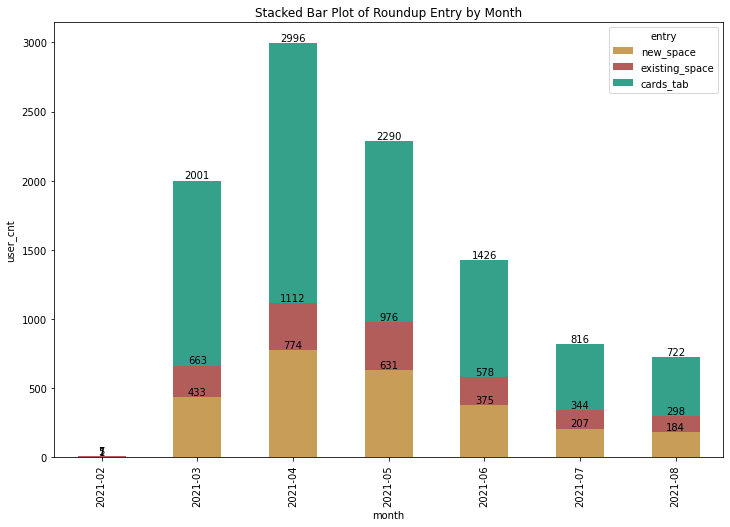

In [9]:
## Plot stacked bar

fig, ax = plt.subplots(figsize=(12, 8))
colors = ["#C89D58", "#B35D5B", "#36A18B"]

entry_pivot.loc[:, ["new_space", "existing_space", "cards_tab"]].plot(
    kind="bar",
    stacked=True,
    color=colors,
    figsize=(12, 8),
    ax=ax,
    title="Stacked Bar Plot of Roundup Entry by Month",
    ylabel="user_cnt",
)
for container in ax.containers:
    ax.bar_label(container)

plt.show()